In [ ]:
%pip install fuzzywuzzy

In [ ]:
%pip install python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.2 MB/s eta 0:00:00


In [ ]:
import networkx as nx

G = nx.from_pandas_edgelist(transitions, 'prev_type', 'type', ['counts'])

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue')
edge_labels = nx.get_edge_attributes(G, 'counts')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import requests
from bs4 import BeautifulSoup
import numpy as np


paronyms = []


# взятие паронимов с открытого ресурса
home_url = 'https://ru-paronym.ru'
ru_alphabet = [chr(i) for i in range(ord('А'), ord('А') + 32)]
no_words = ['Ё', 'Й', 'Щ', 'Ъ', 'Ы', 'Ь']

# Создаем множество всех слов из датасета паронимов
all_words = set()

for letter in ru_alphabet:
    if letter in no_words:
        continue
    url = home_url + '/' + letter
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser')
    arr = soup.find_all('a', href=True)[2:-27]  # Откидываем первые 2 и последние 27 элемента, которые есть на каждой странице
    for elem in arr:
        webpage = home_url + elem['href']
        words = (elem.string).split(' — ')
        paronyms.append([words[0] + '_' + words[1], 1])  # пары слов - паронимы
        paronyms.append([words[1] + '_' + words[0], 1])  # пара в обратном порядке
        all_words.update((words[0], words[1])) # Создаем множество всех слов из датасета паронимов

In [ ]:
# база данных с кортежами с меткой (1) - паронимы
print(paronyms[:20])

[['абонемент_абонент', 1], ['абонент_абонемент', 1], ['абстрактность_абстракция', 1], ['абстракция_абстрактность', 1], ['авантюрин_авантюрист', 1], ['авантюрист_авантюрин', 1], ['автобиографический_автобиографичный', 1], ['автобиографичный_автобиографический', 1], ['автоматический_автоматичный', 1], ['автоматичный_автоматический', 1], ['автономия_автономность', 1], ['автономность_автономия', 1], ['авторитарный_авторитетный', 1], ['авторитетный_авторитарный', 1], ['адресант_адресат', 1], ['адресат_адресант', 1], ['азарт_азартность', 1], ['азартность_азарт', 1], ['академический_академичный', 1], ['академичный_академический', 1]]


In [ ]:
import random

# создание пар слов не паронимов путем перемешивания уже имеющихся слов
def generate_non_paronyms(paronyms, seed = None):

    non_paronyms = []

    if seed:
      random.seed(seed)

    # Случайные пары из множества всех слов
    for _ in range(len(paronyms)):
        word1, word2 = random.choices(list(all_words), k=2)
        if (word1 + ' ' + word2, 1) not in paronyms:
          non_paronyms.append([word1 + '_' + word2, 0])  # Метка 0, так как это непаронимы

    return non_paronyms

non_paronyms = generate_non_paronyms(paronyms, 42)

In [ ]:
dataset_par = paronyms + non_paronyms
random.shuffle(dataset_par) # перемешивание датасета на всякий случай
print(dataset_par[:10])

[['снискать_экологичный', 0], ['целый_цельный', 1], ['бедственный_бесчувствие', 0], ['игольчатый_солярный', 0], ['сыскать_снискать', 1], ['начертать_начертить', 1], ['иноверный_индийский', 0], ['личностный_личный', 1], ['чеканный_чеканочный', 1], ['поедим_гагаровый', 0]]


In [ ]:
import pandas as pd

data = pd.DataFrame(dataset_par, columns=['word_pair', 'label'])
data

,word_pair,label
0,снискать_экологичный,0
1,целый_цельный,1
2,бедственный_бесчувствие,0
3,игольчатый_солярный,0
4,сыскать_снискать,1
...,...,...
3511,гнилой_гнилостный,1
3512,произнесение_грозный,0
3513,абонемент_абонент,1
3514,останки_вдеть,0


from matplotlib import pyplot as plt
data['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [ ]:
#all unique characters go here
tokens = set()
for name in data['word_pair']:
    tokens.update(set(name))

tokens = list(tokens)

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  40


## Convert characters to integers
Torch is built for crunching numbers, not strings. To train our neural network, we'll need to replace characters with their indices in tokens list.

Let's compose a dictionary that does this mapping.

In [ ]:
tokens.append('<') # <SOS>
tokens.append('>') # <EOS>
tokens.append('=') # <PAD>

token_to_id = {token: idx for idx, token in enumerate(tokens)}

assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [ ]:
def to_matrix(
    words, max_len=None, pad=token_to_id['='], dtype='int32', batch_first=True
    ):
    """Casts a list of words into transformer-digestable matrix"""

    max_len = max_len or max(map(len, words))
    max_len += 2
    words_ix = np.zeros([len(words), max_len], dtype) + pad
    words_ix[:, 0] = token_to_id['<'] # <SOS>

    for i in range(len(words)):
        line_ix = [token_to_id[c] for c in words[i]]
        words_ix[i, 1:(len(line_ix) + 1)] = line_ix[:]
        words_ix[i, len(line_ix) + 1] = token_to_id['>'] # <EOS>


    if not batch_first: # convert [batch, time] into [time, batch]
        words_ix = np.transpose(words_ix)

    return words_ix

In [ ]:
print(data['word_pair'][:2])
print('\n', to_matrix(data['word_pair'][:2]))

0    снискать_экологичный
1           целый_цельный
Name: word_pair, dtype: object

 [[40 30 25 19 30  9 15 13  3 26 36  9  0 20  0 22 19 31 25 18  8 41]
 [40 29 24 20 18  8 26 29 24 20  3 25 18  8 41 42 42 42 42 42 42 42]]


In [ ]:
words_matrix = to_matrix(data['word_pair'])

for i in range(len(data['word_pair'])):
    data['word_pair'].iloc[i] = words_matrix[i]

<ipython-input-13-37f2cdd90c9c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['word_pair'].iloc[i] = words_matrix[i]


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class WordPairDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        word_pair, label = self.data.iloc[idx]

        return torch.tensor(word_pair, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# Создание экземпляра датасета
train_dataset = WordPairDataset(data[:3000])
test_dataset = WordPairDataset(data[3001:])

# Создание DataLoader
batch_size = 32
data_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
data_test = DataLoader(test_dataset, batch_size=batch_size,)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SelfAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2, num_heads=8):
        super(SelfAttentionModel, self).__init__()

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.self_attention_layers = nn.ModuleList([
            nn.MultiheadAttention(hidden_size, num_heads) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(1, 0, 2)  # Change the dimensions for Multihead Attention
        for layer in self.self_attention_layers:
            embedded, _ = layer(embedded, embedded, embedded)
        attn_output = embedded.permute(1, 0, 2)  # Reshape to the original dimensions
        attn_output = torch.mean(attn_output, dim=1)  # Take the mean across all attention heads
        output = self.fc(attn_output)
        return output

input_size = 7000
hidden_size = 128
num_layers = 2
num_classes = 2

model = SelfAttentionModel(input_size, hidden_size, num_classes, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 15
loss_arr = []

model.train()

for epoch in range(num_epochs):
    running_loss = 0.0

    for inputs, labels in data_train:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # loss_arr.append(np.mean(loss.data.numpy()))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(data_train)  # средняя ошибка на эпохе
    loss_arr.append(epoch_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}')

Epoch [1/15], Loss: 0.6636743184099806
Epoch [2/15], Loss: 0.482049786029978
Epoch [3/15], Loss: 0.35614610827983695
Epoch [4/15], Loss: 0.298499183253722
Epoch [5/15], Loss: 0.26346357301511664
Epoch [6/15], Loss: 0.22112969994703505
Epoch [7/15], Loss: 0.18736172590325487
Epoch [8/15], Loss: 0.17878119164007775
Epoch [9/15], Loss: 0.16562467278476725
Epoch [10/15], Loss: 0.16390174843291652
Epoch [11/15], Loss: 0.15007677707979653
Epoch [12/15], Loss: 0.14407614591789056
Epoch [13/15], Loss: 0.12805716443727624
Epoch [14/15], Loss: 0.11885015093325142
Epoch [15/15], Loss: 0.12426018471175686


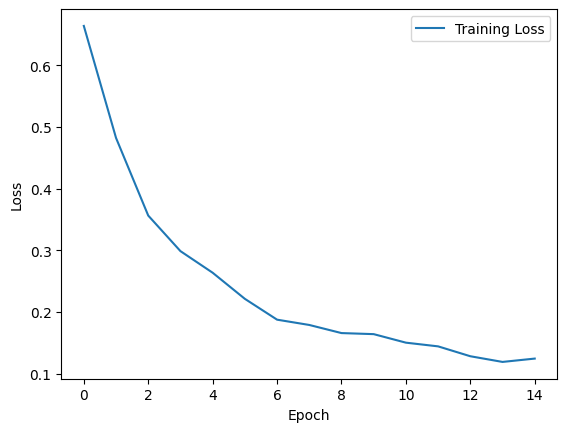

In [ ]:
plt.plot(loss_arr, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():  # Отключение вычисления градиентов
    for inputs, labels in data_test:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Получение индекса класса с максимальной вероятностью

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels, average='binary')
precision = precision_score(true_labels, predicted_labels, average='binary')

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1-score: {2 * precision * recall / (precision + recall)}')

Accuracy: 0.9320388349514563
Recall: 0.9383259911894273
Precision: 0.9102564102564102
F1-score: 0.9240780911062907


In [ ]:
import torch
from torch.nn.functional import softmax

def predict_paronym(model, word_pair):
    model.eval()

    # Convert word_pair to matrix
    word_pair_matrix = to_matrix([word_pair])

    # Convert to torch tensor
    input_tensor = torch.tensor(word_pair_matrix, dtype=torch.long)

    # Make the prediction
    with torch.no_grad():
        output = model(input_tensor)

    # Apply softmax to get probabilities
    probabilities = softmax(output, dim=1)

    # Get the predicted label (1 for paronym, 0 for non-paronym)
    predicted_label = torch.argmax(probabilities, dim=1).item()

    return predicted_label

In [ ]:
# Путь для сохранения модели
model_path = 'model.pth'

# Сохранение весов модели
torch.save(model.state_dict(), model_path)

print(f'Model saved to {model_path}')


Model saved to model.pth


In [ ]:
# Replace 'your_model_path.pth' with the actual path to your saved model
model = SelfAttentionModel(input_size, hidden_size, num_classes, num_layers)
model.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>

In [ ]:
word_pair_to_check = 'свфымсывмфыамфым работа'
predicted_label = predict_paronym(model, word_pair_to_check)

if predicted_label == 1:
    print(f'The word pair "{word_pair_to_check}" is a paronym.')
else:
    print(f'The word pair "{word_pair_to_check}" is not a paronym.')


The word pair "свфымсывмфыамфым работа" is a paronym.


In [ ]:
from fuzzywuzzy import fuzz
import Levenshtein

def levenshtein_distance(dataset): # вычисление расстояния левенштейна и сходства слов
    distances = []

    for (word1, word2), _ in dataset:
        lev_dist = Levenshtein.distance(word1, word2)
        lev_ratio = fuzz.ratio(word1, word2)
        distances.append((word1, word2, lev_dist, lev_ratio))

    return distances

In [ ]:
lev = levenshtein_distance(dataset_par)
lev

ValueError: too many values to unpack (expected 2)